In [1]:
import os
import pathlib
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Mount the remote storage with the dataset
from google.colab import drive
drive.mount('/content/drive')
os.system("unzip -q drive/MyDrive/msa/CatsDogs.zip")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the directory of the dataset
data_dir = pathlib.Path('CatsDogs/')

# Remove corrupted files
os.system("rm CatsDogs/Cats/666.jpg CatsDogs/Dogs/11702.jpg CatsDogs/Dogs/11410.jpg")


# Collects the path of all the files within the dataset
data_paths = [str(path) for path in list(data_dir.glob("*/*.jpg"))]
print(f"Images in the dataset: {len(data_paths)}")

Images in the dataset: 24997


In [ ]:
# Convert non-jpeg images into jpeg files
formats = [(path, Image.open(path).format) for path in data_paths]
non_jpegs = list(filter(lambda x: x[1]!='JPEG', formats))
for path, _ in non_jpegs:
    img = Image.open(path)
    img.convert('RGB').save(path, format='JPEG')

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

In [ ]:
# Create the respective tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
# Shuffle the dataset
dataset = dataset.shuffle(len(data_paths))

In [ ]:
# Get the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Cats' 'Dogs']


In [ ]:
# Create a test set
test_size = int(len(list(dataset)) * 0.2)
train = dataset.skip(test_size)
test = dataset.take(test_size)

# Create a validation set
val_size = int(len(list(train)) * 0.2)
train = train.skip(val_size)
val = train.take(val_size)

In [ ]:
# Set initial params for the loader
batch_size = 64
img_height = 150
img_width = 150

In [ ]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
# Create a dataset of image, label pairs
train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train = configure_for_performance(train)
val = configure_for_performance(val)
test = configure_for_performance(test)

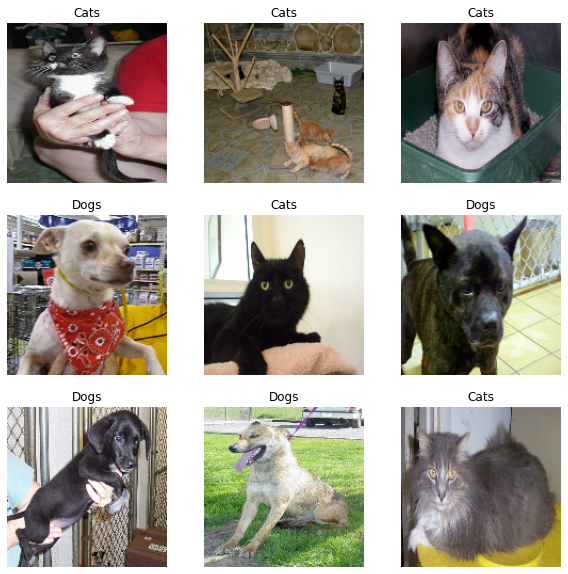

In [ ]:
image_batch, label_batch = next(iter(train))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [ ]:
num_classes = 1

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
n_epochs = 10

model.fit(
    train,
    validation_data=val,
    epochs=n_epochs
)

Epoch 1/10
250/250 [==============================] - 50s 145ms/step - loss: 0.6279 - accuracy: 0.6317 - val_loss: 0.5360 - val_accuracy: 0.7412
Epoch 2/10
250/250 [==============================] - 10s 41ms/step - loss: 0.5127 - accuracy: 0.7467 - val_loss: 0.4519 - val_accuracy: 0.7797
Epoch 3/10
250/250 [==============================] - 10s 41ms/step - loss: 0.4434 - accuracy: 0.7930 - val_loss: 0.4055 - val_accuracy: 0.8157
Epoch 4/10
250/250 [==============================] - 10s 41ms/step - loss: 0.3872 - accuracy: 0.8221 - val_loss: 0.3698 - val_accuracy: 0.8337
Epoch 5/10
250/250 [==============================] - 10s 41ms/step - loss: 0.3313 - accuracy: 0.8532 - val_loss: 0.3257 - val_accuracy: 0.8587
Epoch 6/10
250/250 [==============================] - 10s 41ms/step - loss: 0.2721 - accuracy: 0.8842 - val_loss: 0.3149 - val_accuracy: 0.8680
Epoch 7/10
250/250 [==============================] - 10s 40ms/step - loss: 0.2152 - accuracy: 0.9094 - val_loss: 0.2894 - val_accuracy

In [ ]:
model.evaluate(test)

79/79 [==============================] - 8s 87ms/step - loss: 0.2952 - accuracy: 0.9154


[0.2952353060245514, 0.9153831005096436]

In [ ]:
def zero_one_loss(dataset):
    data = []
    y_truth = []

    for batch in dataset.as_numpy_iterator():
        data += [*batch[0]]
        y_truth += [*batch[1]]

    y_pred_binary = np.around(model.predict(np.asarray(data))).flatten()
    missmatches = np.logical_xor(y_pred_binary, y_truth)
    
    return tf.math.reduce_sum(tf.cast(missmatches, tf.int32)).numpy()

In [ ]:
zero_one_loss(test)

# K-fold cross validation

In [ ]:
from random import shuffle
from sklearn.model_selection import KFold



shuffle(data_paths)
k_fold = KFold(n_splits=5)
k_splits = k_fold.split(data_paths)
results = []
zero_one_losses = []

for train_index, test_index in k_splits:

    # Clear any previous state
    del model
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # Get the paths to the data
    train_paths = np.asarray(data_paths)[train_index]
    test_paths = np.asarray(data_paths)[test_index]

    # Make it tf.data.Dataset
    train = tf.data.Dataset.from_tensor_slices(train_paths)
    test = tf.data.Dataset.from_tensor_slices(test_paths)
    
    # Get labels
    train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Configure for performance
    train = configure_for_performance(train)
    test = configure_for_performance(test)

    # Create the model
    num_classes = 1
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    model.fit(
        train,
        epochs=n_epochs,
        verbose=0
    )
    
    results.append(model.evaluate(test))
    zero_one_losses.append(zero_one_loss(test))

In [ ]:
loss = np.mean(zero_one_losses)
accuracy = np.mean([result[1] for result in results])
print(loss, accuracy)